In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Preprocessing
Dataset has 122 predictive, 5 non-predictive, 1 goal
- Remove 5 non-predictive features: state, county, community, communityname, fold
- replace missing values by NaN
- describe missing features
- remove features that has many missing values

In [75]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
print(X.shape, y.shape)
df = pd.concat([X, y], axis=1)
print(df.shape, df.columns)

(1994, 127) (1994, 1)
(1994, 128) Index(['state', 'county', 'community', 'communityname', 'fold', 'population',
       'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=128)


In [76]:
df = df.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], axis=1)

In [77]:
# replacing missing values by NaN
# describe missing features
df = df.replace('?', np.nan)
feat_miss = df.columns[df.isnull().any()]
print(feat_miss)
print(feat_miss.shape)
df[feat_miss[0:23]].describe()

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')
(23,)


,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,...,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,...,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,...,0,0.07,0.03,0.57,0.19,0.02,0.02,0.74,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,...,189,14,48,54,12,27,69,13,126,22


OtherPerCap has only one missing, but others has lots of -> remove them 

In [78]:
# Impute mean values for samples with missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(df[['OtherPerCap']])
df[['OtherPerCap']] = imputer.transform(df[['OtherPerCap']])

In [79]:
# drop all NaN
df = df.dropna(axis=1)
print(df.shape)
df.head()

(1994, 101)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


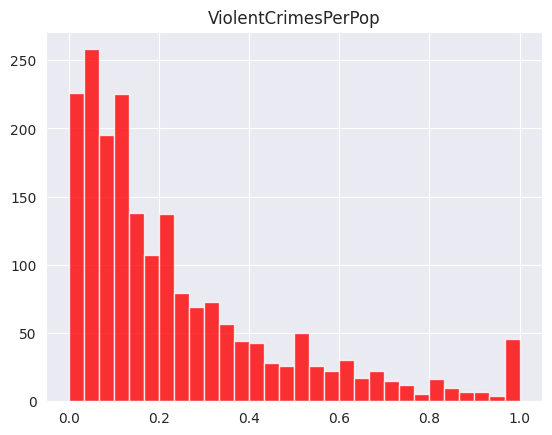

In [80]:
#histogram of violent crimes per pop
y.hist(column = ['ViolentCrimesPerPop'], bins = 30, color = 'red', alpha = 0.8)
plt.show()

# Examine Correlations
Analyze correlations between sensitive attributes (e.g. race, income) and target variables (e.g. crime rate)
Strong correlations might indicate proxy variables for sensitive attributes, potentially introducing bias 

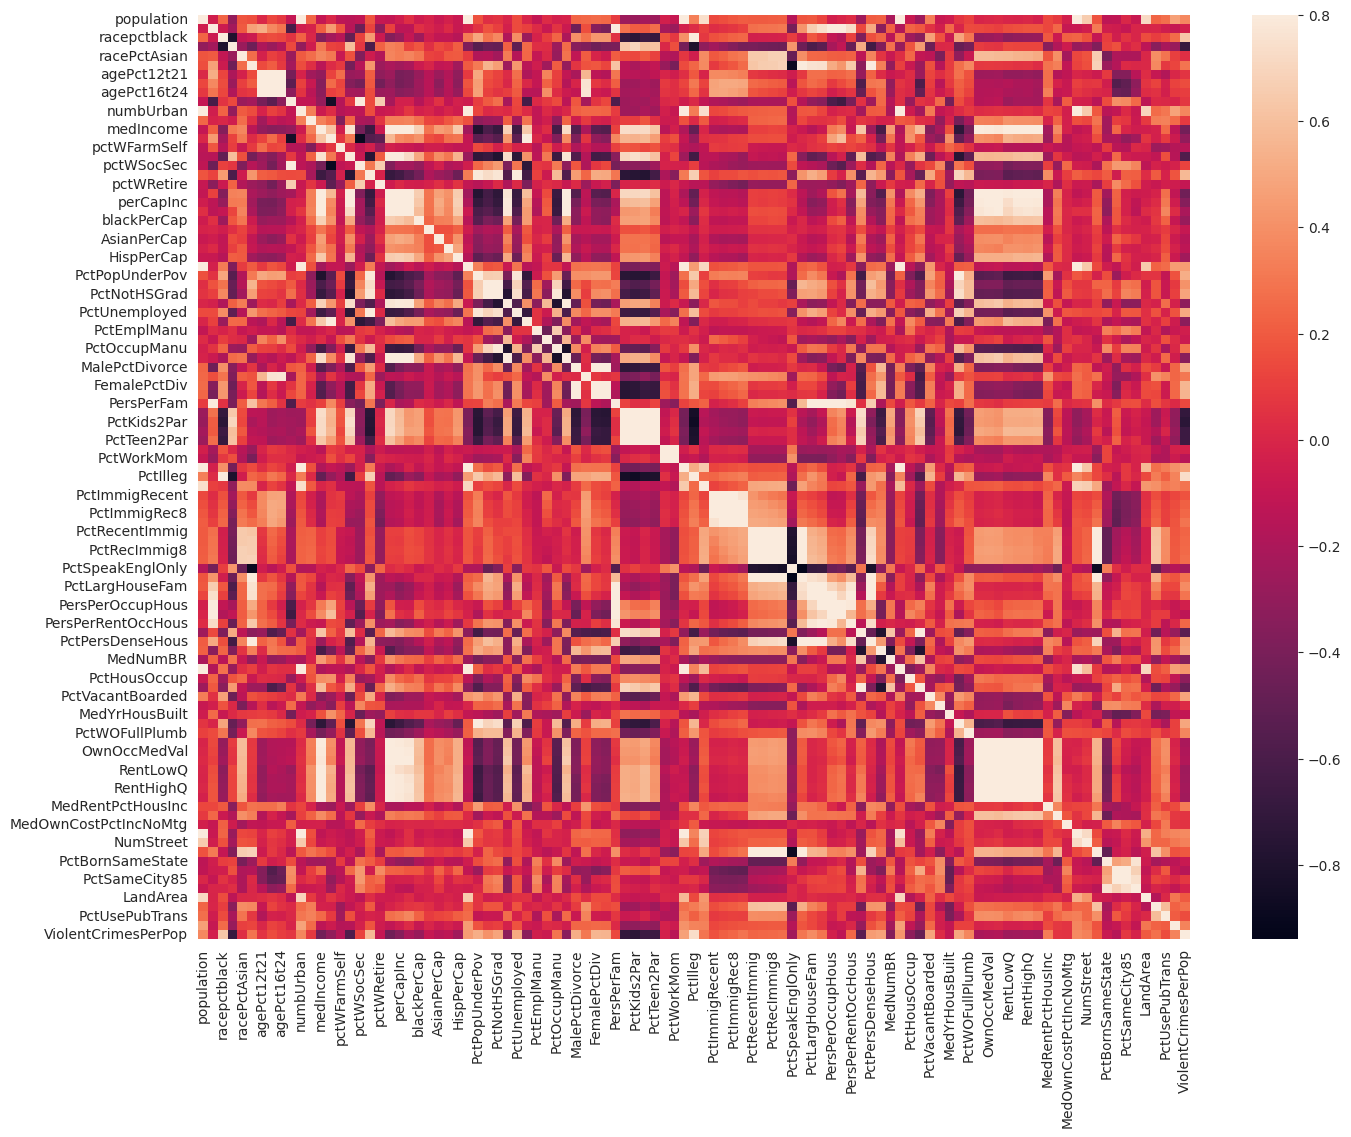

In [81]:
import seaborn as sns
corrmat = df.corr()
fig = plt.figure(figsize = (16, 12))

sns.heatmap(corrmat, vmax = 0.8)
plt.show()

In [82]:
corrT = df.corr(method = 'pearson').round(4)
corrT = corrT.sort_values(by=['ViolentCrimesPerPop'])
corrT['ViolentCrimesPerPop']

PctKids2Par           -0.7384
PctFam2Par            -0.7067
racePctWhite          -0.6848
PctYoungKids2Par      -0.6661
PctTeen2Par           -0.6616
                        ...  
FemalePctDiv           0.5560
pctWPubAsst            0.5747
racepctblack           0.6313
PctIlleg               0.7380
ViolentCrimesPerPop    1.0000
Name: ViolentCrimesPerPop, Length: 101, dtype: float64

In [83]:
def get_train_test_set(data, ratio=0.3, seed=0):
    from sklearn.model_selection import train_test_split
    X = data.iloc[:, 0:100].values
    y = data.iloc[:, 100].values
    return train_test_split(X, y, test_size = ratio, random_state = seed)

# Principal component analysis (PCA)

In [84]:
X_train, X_test, y_train, y_test = get_train_test_set(df)
print(X_train.shape)

(1395, 100)


In [85]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Amount of variance: [25.20144365 16.45250595  9.49203575  7.5706022   5.82744092  4.29215461
  3.35028834  2.87773896  2.05180556  1.57904439  1.55973253  1.46898657
  1.3886407   1.03153866]
Sum of the variance: 84.14
Percentage of variance: [0.25183378 0.16440712 0.09485231 0.07565175 0.05823264 0.04289078
 0.03347887 0.02875676 0.02050335 0.01577912 0.01558614 0.01467934
 0.01387645 0.01030799]
Sum of the percentage of variance: 0.84


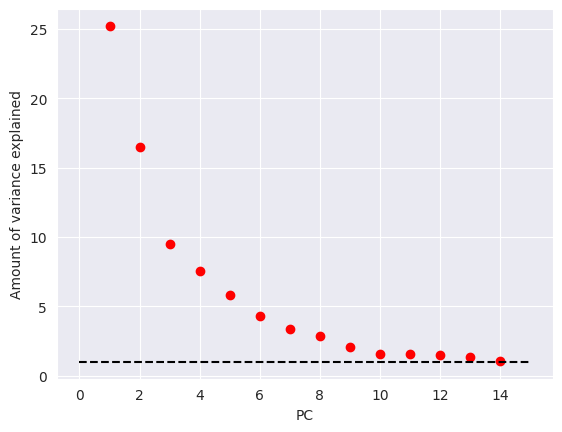

(1395, 14)


In [86]:
from sklearn.decomposition import PCA

c = 14
pca = PCA(n_components = c)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
components = pca.components_

print("Amount of variance: %s" % pca.explained_variance_)
print("Sum of the variance: %s" % sum(pca.explained_variance_).round(2))

print("Percentage of variance: %s" % pca.explained_variance_ratio_)
print("Sum of the percentage of variance: %s" % sum(pca.explained_variance_ratio_).round(2))


plt.scatter(np.arange(1,(c+1)),pca.explained_variance_, c = 'red')
plt.plot((0,15), (1,1), color = 'black', linestyle = 'dashed')
plt.xlabel('PC')
plt.ylabel('Amount of variance explained')
plt.show()
print(X_train.shape)

In [87]:
for name, model in [('LR', LinearRegression()), ('SVR', SVR())]:
    seed = 0
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv = cv, scoring = make_scorer(r2_score))
    print("%s: %.3f (+/- %.3f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.642 (+/- 0.028)
SVR: 0.615 (+/- 0.032)


Linear regression has the best performance of R^2 = 0.642

In [88]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
nrp = X_test.shape[1]+1
rms = np.sqrt(sum((y_test-y_pred_test)**2)/(len(y_test)-nrp))

print('R^2: %.4f' % r2_score(y_test,y_pred_test))
print('MSE: %.4f' % mean_squared_error(y_test,y_pred_test))
print('MAE: %.4f' % mean_absolute_error(y_test,y_pred_test))
print('rms: %.4f' % rms)

R^2: 0.6241
MSE: 0.0202
MAE: 0.0981
rms: 0.1438


In [89]:
from scipy import stats
stats.describe(y_test)

DescribeResult(nobs=599, minmax=(0.0, 1.0), mean=0.2337228714524207, variance=0.05374447825528613, skewness=1.534500221499714, kurtosis=1.8160161830237582)

# Fairness 
- statistics of goal feature
ViolentCrimesPerPop 0 1 0.24 0.23 1.00 0.15 0.03 0
- Distribution of the Goal Variable (Violent Crimes per Population):
Range Frequency
0.000-0.067 484
0.067-0.133 420
0.133-0.200 284
0.200-0.267 177
0.267-0.333 142
0.333-0.400 113
0.400-0.467 59
0.467-0.533 76
0.533-0.600 57
0.600-0.667 38
0.667-0.733 37
0.733-0.800 20
0.800-0.867 23
0.867-0.933 14
0.933-1.000 50

## Measure fairness
### Demographic parity 
form demographic groups from dataset 
demographic information can be population density, racial composition, age distribution 
- for example:
Two groups, categorized by `racepctblack`: 
  - Low (choose a threshold) 
  - High 
Compute demographic parity for two groups above 
- Tool: ANOVA, Kolmogorov-Smirnov test 

In [90]:
# group dataset into two groups based on `racepctblack`
df['race_group'] = np.where(df['racepctblack'] < 0.10, 'Low', 'High')
# compute mean or median of ViolentCrimesPerPop for each group 
mean_crime_rates = df.groupby('race_group')['ViolentCrimesPerPop'].mean()
print("Mean Violent Crime Rates by Race Group:")
print(mean_crime_rates)

Mean Violent Crime Rates by Race Group:
race_group
High    0.378504
Low     0.139420
Name: ViolentCrimesPerPop, dtype: float64


If percentage of population that is african american is high, mean of ViolentCrimesPerPop is 0.38, higher than mean for low group. 
Two group has quite equal population

In [91]:
df['race_group'].describe()

count     1994
unique       2
top        Low
freq      1172
Name: race_group, dtype: object

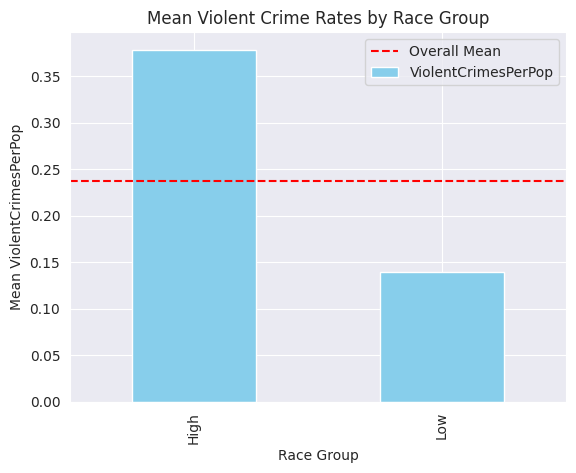

In [92]:
import matplotlib.pyplot as plt

mean_crime_rates.plot(kind='bar', color='skyblue')
plt.title('Mean Violent Crime Rates by Race Group')
plt.xlabel('Race Group')
plt.ylabel('Mean ViolentCrimesPerPop')
plt.axhline(df['ViolentCrimesPerPop'].mean(), color='red', linestyle='--', label='Overall Mean')
plt.legend()
plt.show()

In [93]:
from scipy.stats import ttest_ind

# Split data into two groups
low_group = df[df['race_group'] == 'Low']['ViolentCrimesPerPop']
high_group = df[df['race_group'] == 'High']['ViolentCrimesPerPop']

# Perform t-test
t_stat, p_value = ttest_ind(low_group, high_group)

print(f"T-Statistic: {t_stat}, P-Value: {p_value<0.05}")

T-Statistic: -26.13083466560249, P-Value: True


p-value < 0.05 -> difference is significant 

### Measure fairness in model 